In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.dates as mdates
import matplotlib as mpl
import numpy as np
import seaborn as sns

import torch

## Análisis de sentimiento de los comentarios

En este notebook, vamos a realizar un análisis llamado "Análisis de sentimiento", en el que se explora el sentimiento de un texto, en este caso será el de los comentarios, y para ellos vamos a utilizar un modelo llamado __pysentimiento/robertuito-sentiment-analysis__, del hub de __HuggingFace__. Esta modelo nos ayudará a clasificar los comentarios con una escala de "positivo", "neutro", y "negativo".

(Si deseas información sobre Huggingface puedes entrar en su web, allí hay muchos tutoriales que te ayudarán a entender su uso, y de los cuales me base para realizar el análisis que aquí realizo)

Una vez que hayamos aplicado el análisis de sentimiento, crearemos un gráfico de barras para visualizar la distribución del sentimiento, esto nos dará una idea general de lo que piensa la audiencia y nos ayudará a comprender sus opiniones sobre los videos. Así que, ¡Sumerjámonos en el código y veamos qué conclusiones podemos obtener del análisis de sentimiento!

In [2]:
import re
import unicodedata
from pysentimiento import create_analyzer

def clean_text(text):
    # Convierte el texto a minúsculas
    text = text.lower()

    # Elimina las puntiaciones
    text = re.sub(r'[^\w\s]', '', text)

    # Remueve los acentos
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')

    return text

def sentiment_analysis(df, column, threshold=0.95):
    """
    Realiza un análisis de sentimiento de los comentarios en un dataframe usando un modelo de Huggingface.
    
    Args:
    - df (pandas.DataFrame): dataframe con los comentarios en formato de texto.
    - columna (str): nombre de la columna del dataframe que contiene los comentarios.
    
    Returns:
    - pandas.DataFrame: dataframe con una nueva columna "sentimiento" que indica el sentimiento de cada comentario
                        ("positivo", "negativo" o "neutro").
    """

    df = df.dropna()

    analyzer = create_analyzer(task="sentiment", lang="es")

    df[column] = df[column].apply(clean_text)

    df['sentimiento'] = df[column].apply(lambda x: analyzer.predict(x).output)

    return df


Creamos una nueva columna con la clasifiación de sentimientos de cada comentario.

In [3]:
# Ahora procedemos a cambiar los valores de la columna sentimiento, de "POS" -> "positivo".
def reemplazar(x):
    if x == 'POS':
        return 'Positivo'
    elif x == 'NEG':
        return 'Negativo'
    elif x == 'NEU':
        return 'Neutro'
    else:
        return np.NaN

In [ ]:
# Esta celda solo será ejecutada si no se quiere utilizar el archivo previamente procesado, y generar uno nuevo.

# comments_df = sentiment_analysis(comments_df, 'comment_text', threshold=0.95)

# comments_df['sentimiento'] = comments_df['sentimiento'].apply(reemplazar)

Como ya hemos ejecutado esta tarea, vamos entonces a cargar el resultado:

In [5]:
comments_xls = 'Comentarios-FreeCover-Sentimiento(v2).xlsx'
comments_path = os.path.join('Comentarios',comments_xls)
comments_df = pd.read_excel(comments_path, index_col=0)
comments_df['sentimiento'] = comments_df['sentimiento'].apply(reemplazar)

## Revisión de los resultados

Veamos algunos ejemplos de la salida del procesamiento de análisis de sentimiento con el modelo "vainilla".

Primero veamos algunos comentarios que fueron clasificados como positivos:

In [11]:
pd.set_option('display.max_colwidth', None)
comments_df[comments_df['sentimiento']=='Positivo'].loc[:,['comment_text','sentimiento']].head(5)

,comment_text,sentimiento
1,debo reconocer que este free cover y el de juan miguel son unos de mis favoritos me gustaria verlos de nuevo en free cover aparte de que como maracucho estoy super orgulloso de donde han llegado han llevado el nombre de venezuela en alto y eso es para aplaudirllos,Positivo
3,enamorada de los freecover,Positivo
4,un free cover de guacode adolescentes los primera tanto talento venezolano bendiciones y felicitaciones por cada cover que nos dan,Positivo
8,dfntvmnt hermoso naturalmente impecable,Positivo
9,me encanta,Positivo


El modelo sin modificar parace ser bueno, ahora veamos algunos comentarios negativos:

In [12]:
pd.set_option('display.max_colwidth', None)
comments_df[comments_df['sentimiento']=='Negativo'].loc[:,['comment_text','sentimiento']].head(5)

,comment_text,sentimiento
62,yo nada mas vine a ver que tan sucia tenia la franela el neg,Negativo
72,no sabian la magnitud de lo que crearon 4 anos despues y estos chamos se superaron mil veces exitos freecovervenezuela,Negativo
89,el que hizo las tomas lo que hace es marear al que ve el video,Negativo
179,comparado a todos los demas artistas que han estado en free cover venezuela se nota que sufriste para cantar en vivo juan miguel acostumbradito a las pistas,Negativo
212,no paro de reproducir este video brutal,Negativo


Sin embargo, para los comentarios clasificados como negativos, vemos que el desempeño del modelo es no es el mejor. En estos casos lo que se sugiere es realizar un proceso de "fine-tuning" al modelo NLP, este proceso consiste básicamente en mostrar algunos cientos de ejemplos con la nueva tarea (en nuestro caso, es etiquetar manualmente algunos ejemplos del conjunto de datos), y volver a entrenar al modelo con estos ejemplos, lo que se ha demostrado que funciona en los siguientes papers:

    "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding" por Jacob Devlin, Ming-Wei Chang, Kenton Lee, y Kristina Toutanova. Este paper introdujo el modelo BERT (Bidirectional Encoder Representations from Transformers), que se pre-entrena en grandes corpus de texto y luego se sintoniza (fine-tuning) para tareas específicas. El paper muestra que el fine-tuning de BERT en una variedad de tareas de procesamiento de lenguaje natural, como clasificación de texto y respuesta a preguntas, supera a los enfoques existentes y establece nuevos estados del arte.

    "RoBERTa: A Robustly Optimized BERT Pretraining Approach" por Yinhan Liu, Myle Ott, Naman Goyal, Jingfei Du, Mandar Joshi, Danqi Chen, Omer Levy, Mike Lewis, Luke Zettlemoyer, y Veselin Stoyanov. En este paper, los autores presentan RoBERTa, una variante de BERT que se pre-entrena con algunas mejoras en el proceso de entrenamiento. Luego, realizan fine-tuning en una amplia gama de tareas de NLP, incluyendo clasificación de texto, respuesta a preguntas y modelado de lenguaje. Los resultados demuestran que RoBERTa supera a BERT en varias tareas y establece nuevos estados del arte.

## Analisis de los datos

Ahora realizaremos un analisis de los datos basandonos en la clasificación de sentimiento realizada por el modelo __pysentimiento/robertuito-sentiment-analysis__ en las celda anteriores.

Para más información sobre el modelo puedes visitar su página en el hub de huggingface [robertuito-sentiment-analysis](https://huggingface.co/pysentimiento/robertuito-sentiment-analysis/discussions/2)

Comencemos con una visualización sobre la distribución del sentimiento.

## Visualización de la Distribución de Sentimientos

En el análisis de sentimientos, comprender la distribución de los diferentes sentimientos en un conjunto de datos es fundamental para obtener información valiosa. Una forma efectiva de visualizar esta distribución es a través de gráficos claros y concisos. En esta sección, exploraremos una visualización de la distribución de sentimientos utilizando un gráfico de barras:

In [13]:
import matplotlib.ticker as ticker

def plot_sentiment_analysis(df, columna):
    """
    La función plot_sentiment_analysis grafica la distribución de sentimientos en un DataFrame utilizando seaborn.

    Argumentos:

        df: un DataFrame de pandas que contiene los datos de análisis de sentimiento.

    Retorno:

        No devuelve ningún valor, pero muestra el gráfico de barras generado con matplotlib y seaborn.
    """

    # Definir el orden de las categorías para el eje x
    sentimiento_order = ['Positivo', 'Neutro', 'Negativo']

    # Plot a bar chart of the sentiment distribution
    fig, ax = plt.subplots(figsize=(12,5))
    sns.set_style('whitegrid')
    sns.countplot(x=columna, data=df, palette="hsv", order=sentimiento_order)
    ax.set_title("Distribución de sentimiento")
    ax.set_xlabel("Sentimiento")
    ax.set_ylabel("Conteo")
    plt.xticks(rotation=45, ha='right')

    # Formatea los valores del eje "Y" para que tenga separador de "miles"
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    # Add labels to the bars
    for p in ax.patches:
        ax.annotate(
            format(p.get_height(), ','),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha = 'center', va = 'center', xytext = (0, 10),
            textcoords = 'offset points'
            )
        
    plt.show()


Creamos la visualización:

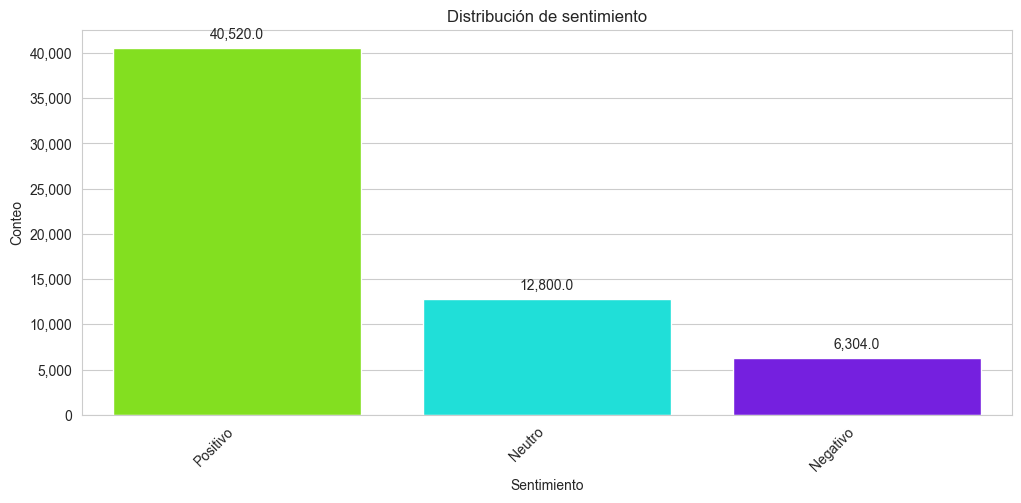

In [15]:
plot_sentiment_analysis(comments_df, 'sentimiento')

* El 69 % de los comentarios son positivos, los resultados hablan por si solos, la gran mayoría de las personas que comentan los videos de __FreeCover Venezuela__ expresan sentimientos positivos, debido al carisma y actitud contagiosa de los artistas que se presentan para cantar y tocar sus instrumentos.


* Los comentarios "Neutros" en su mayoría son consultas, y peticiones de nuevos artistas invitados.


* Por supuesto que existen comentarios negativos de personas a las que no les gusta el contenido, sin embargo, y para fortuna de los creadores del canal, estos representan cerca de un 6 % de los comentarios.


* El modelo utilizado tiene un "Macro F1 Score" de sobre 70 % en tareas de analisis de sentimiento en texto en español, por lo que como vimos en algunos ejemplos, parte de los comentarios son clasificados de manera erronea.

* Cerca del 28 % de los comentarios no fueron clasificados por el sistema, lo cuál será corregido en el proceso de fine-tuning.

## Relación Positivo vs Negativo

Una característica interesante de observar sería la relación entre la cantidad de comentarios positivos a negativos, por lo que de nuevo nos vamos a apoyar en una visualización. Está vez será una gráfica de torta, que nos muestre dicha relación, la cual vamos a obtener al dividir la cantidad de comentarios __positivos__ sobre los __negativos__ de los videos, y finalmente, graficaremos el video con la mejor, y la peor relación.

Para poder hacer lo comentado anteriormente crearemos entonces una función que nos ayude con eso:

In [25]:
def plot_best_worst_videos(df):
    """
    Función que grafica los dos videos con la mayor y menor proporción positiva a negativa de comentarios en un DataFrame.

    Argumentos:
        df: un DataFrame de pandas que contiene los datos de comentarios de los videos.

    Retorno:
        No devuelve ningún valor, pero muestra el gráfico de pastel generado con matplotlib.
    """

    df = df.dropna()

    # Calcula la proporción positiva a negativa de comentarios para cada video
    video_sentiment = df.groupby('video_title')['sentimiento'].value_counts(normalize=True).unstack().fillna(0)
    video_sentiment['ratio'] = video_sentiment['Positivo'] / video_sentiment['Negativo']
    
    # Check if any video has no negative comments
    has_no_negative = (video_sentiment['Negativo'] == 0).any()
    
    if has_no_negative:
        # Select the video with the highest positive-to-negative ratio that has at least one negative comment
        video_sentiment_filtered = video_sentiment[video_sentiment['Negativo'] > 0]
        best_video = video_sentiment_filtered['ratio'].idxmax()
        worst_video = video_sentiment_filtered['ratio'].idxmin()
    else:
        # Select the videos with the highest and lowest positive-to-negative ratios
        best_video = video_sentiment['ratio'].idxmax()
        worst_video = video_sentiment['ratio'].idxmin()
    
    best_ratio = video_sentiment.loc[best_video, 'ratio']
    worst_ratio = video_sentiment.loc[worst_video, 'ratio']

    # Filtra los comentarios de los dos videos seleccionados
    best_comments = df[df['video_title'] == best_video]
    worst_comments = df[df['video_title'] == worst_video]

    # Configuración de los colores
    colors = ['#3CB371', '#4169E1', '#FF6347']
    labels = ['Positivo', 'Neutro', 'Negativo']

    # Grafica la distribución de sentimientos de los dos videos con pastel
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    plt.suptitle(f"Mejor y peor video (proporción pos/neg: {best_ratio:.2f} / {worst_ratio:.2f})", fontsize=16)
    
    # Grafica pastel para el mejor video
    best_data = best_comments['sentimiento'].value_counts(normalize=True)
    ax1.pie(best_data, colors=colors, startangle=90, autopct='%1.1f%%', labels=labels)
    ax1.set_title(f"Mejor video: {best_video}")
    
    # Grafica pastel para el peor video
    worst_data = worst_comments['sentimiento'].value_counts(normalize=True)
    ax2.pie(worst_data, colors=colors, startangle=90, autopct='%1.1f%%', labels=labels)
    ax2.set_title(f"Peor video: {worst_video}")

    plt.show()

Ahora vemos la imagen:

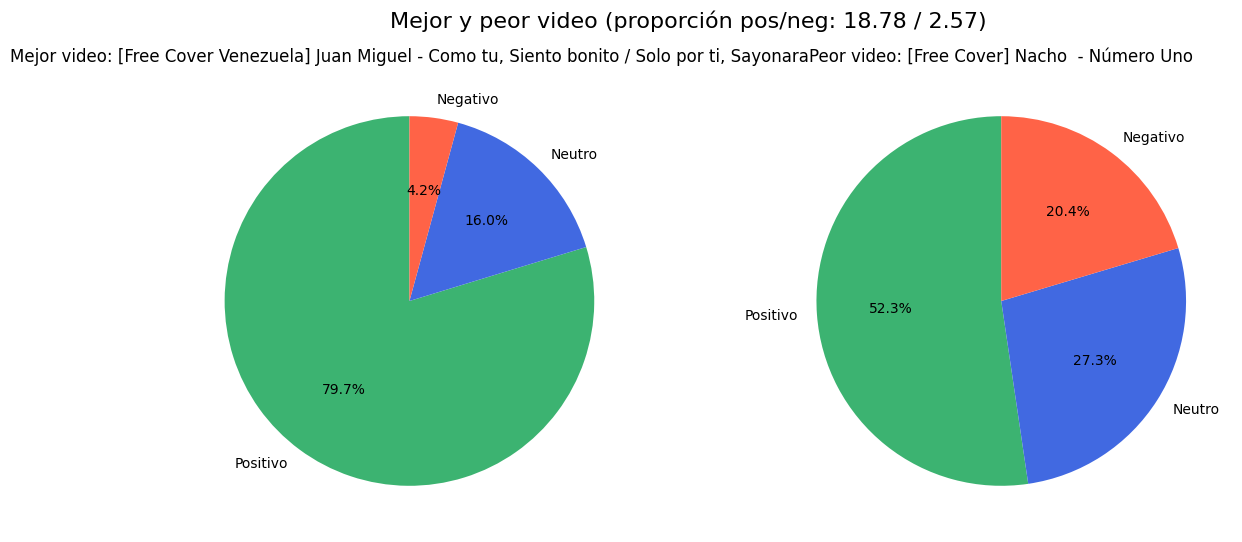

In [26]:
plot_best_worst_videos(comments_df)

* El video con la mejor relación de comentarios positivos a negativos es el video __[Free Cover Venezuela] Juan Miguel - como tú, SIento bonito / Solo por tí, Sayonara__, con una tasa de 18,78 comentarios positivos por cada comentario negativo. Sin embargo, este video es uno de los que menos comentarios tiene, por lo que modificaremos la función para que filtre los videos con menos de 1000 comentarios y los deje fuera.

In [51]:
def plot_best_worst_videos(df, columna):
    """
    Función que grafica los dos videos con la mayor y menor proporción positiva a negativa de comentarios en un DataFrame.

    Argumentos:
        df: un DataFrame de pandas que contiene los datos de comentarios de los videos.

    Retorno:
        No devuelve ningún valor, pero muestra el gráfico de pastel generado con matplotlib.
    """

    # df = df.dropna()

    # Filtra los videos con menos de 1000 comentarios
    df = df.groupby('video_title').filter(lambda x: len(x) >= 1000)

    # Calcula la proporción positiva a negativa de comentarios para cada video
    video_sentiment = df.groupby('video_title')[columna].value_counts(normalize=True).unstack().fillna(0)
    video_sentiment['ratio'] = video_sentiment['Positivo'] / video_sentiment['Negativo']
    
    # Check if any video has no negative comments
    has_no_negative = (video_sentiment['Negativo'] == 0).any()
    
    if has_no_negative:
        # Select the video with the highest positive-to-negative ratio that has at least one negative comment
        video_sentiment_filtered = video_sentiment[video_sentiment['Negativo'] > 0]
        best_video = video_sentiment_filtered['ratio'].idxmax()
        worst_video = video_sentiment_filtered['ratio'].idxmin()
    else:
        # Select the videos with the highest and lowest positive-to-negative ratios
        best_video = video_sentiment['ratio'].idxmax()
        worst_video = video_sentiment['ratio'].idxmin()
    
    best_ratio = video_sentiment.loc[best_video, 'ratio']
    worst_ratio = video_sentiment.loc[worst_video, 'ratio']

    # Filtra los comentarios de los dos videos seleccionados
    best_comments = df[df['video_title'] == best_video]
    worst_comments = df[df['video_title'] == worst_video]

    # Configuración de los colores
    colors = ['#3CB371', '#4169E1', '#FF6347']
    labels = ['Positivo', 'Neutro', 'Negativo']

    # Grafica la distribución de sentimientos de los dos videos con pastel
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    plt.suptitle(f"Mejor y peor video (proporción pos/neg: {best_ratio:.2f} / {worst_ratio:.2f})", fontsize=16)
    
    # Grafica pastel para el mejor video
    best_data = best_comments[columna].value_counts(normalize=True)
    ax1.pie(best_data, colors=colors, startangle=90, autopct='%1.1f%%', labels=labels)
    ax1.set_title(f"Mejor video: {best_video}")
    
    # Grafica pastel para el peor video
    worst_data = worst_comments[columna].value_counts(normalize=True)
    ax2.pie(worst_data, colors=colors, startangle=90, autopct='%1.1f%%', labels=labels)
    ax2.set_title(f"Peor video: {worst_video}")

    plt.show()


Ahora si, veamos el resultado:

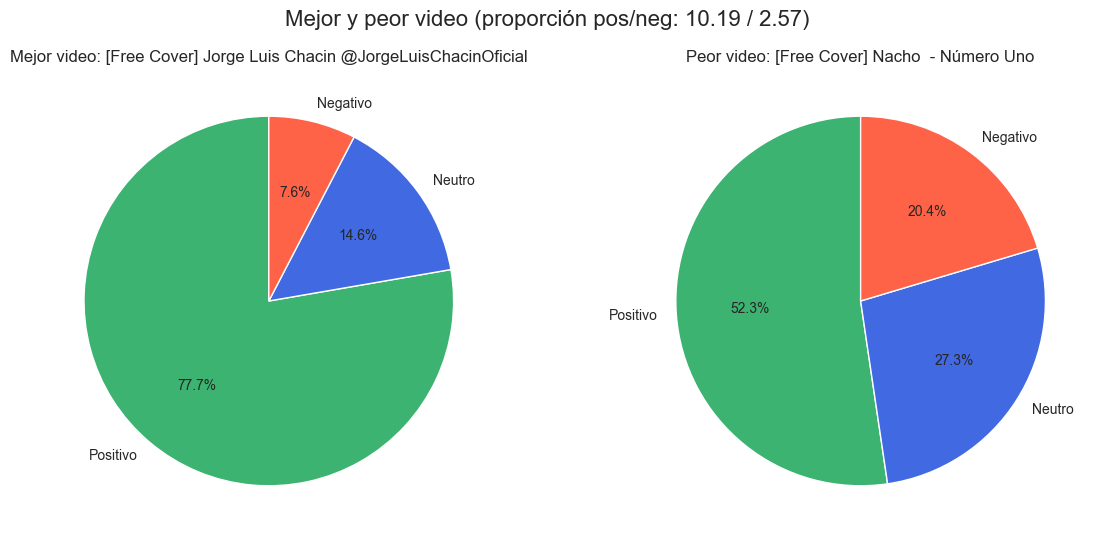

In [52]:
plot_best_worst_videos(comments_df, 'sentimiento')

* El video con la mejor relación de comentarios buenos a malos es el video de __Jorge Luís Chacín__, con una relación de 10,19 a 1.
* El video con la peor relación es el de __Nacho__ Numero 1. con una relación de 2,57 a uno.

Es importante recordar que el modelo sin cambios utilizado tiene un Macro F1 Score de 70 según la página de Huggingface, por lo que con la finalidad de dar un resultado más certero es necesario que realicemos el proceso de "Sintonía fina" al modelo (fine-tuning). Para esto nos vamos a apoyar en las herramientas provistas por la misma plataforma Huggingface.

El proceso de __fine-tuning__ del modelo lo realizaremos en un notebook "Colab" separado, esto se debe a que para poder realizar este tipo de procesos en un tiempo prudencialmente bajo es necesario contar con aceleradores gráficos (GPUs), los cuales son proporcionados de manera gratuita por la plataforma "Google Colab"

# Post Fine-tuning

Una vez ejecutado el "Colab" de fine-tuning podemos venir aquí y cargar el archivo generado que contiene una nueva columna con la nueva clasificación, lo cual haremos a continuación:

In [4]:
fine_tune_comments_xls = 'Comentarios_clasificados_fine-tuned-FreeCover(v2).csv'
fine_tune_comments_path = os.path.join('Comentarios',fine_tune_comments_xls)
fine_tune_comments_df = pd.read_csv(fine_tune_comments_path, index_col=0, encoding='latin1', sep=';')
fine_tune_comments_df['fine-tuned_label'] = fine_tune_comments_df['fine-tuned_label'].apply(reemplazar)
# fine_tune_comments_df['manual_label'] = fine_tune_comments_df['manual_label'].apply(reemplazar)

Observemos parte de los datos:

In [35]:
fine_tune_comments_df[fine_tune_comments_df['comment_text'].str.contains('nacho')]

,video_id,video_title,video_date,comment_text,comment_date,sentimiento,manual_label,fine-tuned_label
812,Oqcqnxjwp8Q,[Free Cover] Ronald Borjas - Medley,2018-07-16 02:35:14,para cuando se iran a anotar a ganador chino y...,2018-07-16 02:35:14,NaN,NEU,Neutro
2293,Q2kQbIrEB8I,"[Free Cover] Ricardo Cepeda ""El Colosal"" - Med...",2018-12-20 20:01:50,aca inicio todo de aqui hasta nacho cuantas co...,2018-12-20 20:01:50,POS,NaN,Positivo
3364,Q2kQbIrEB8I,"[Free Cover] Ricardo Cepeda ""El Colosal"" - Med...",2018-12-20 20:01:50,como hacen para reunir a los fantasticos me im...,2018-12-20 20:01:50,POS,NaN,Neutro
3730,Q2kQbIrEB8I,"[Free Cover] Ricardo Cepeda ""El Colosal"" - Med...",2018-12-20 20:01:50,esta gente no juega carrito tienen que hacer ...,2018-12-20 20:01:50,NEU,NaN,Neutro
5739,dYcc91x3B6k,[Free Cover] Rafael Pollo Brito - Homenaje a L...,2020-02-28 21:05:52,un free cover con nacho por favor los en vivo ...,2020-02-28 21:05:52,NEG,NaN,Positivo
...,...,...,...,...,...,...,...,...
66632,NESKQr1e8Rs,[Free Cover] Horacio Blanco - Desorden Publico,2022-12-10 01:00:08,free cover de verdad siempre sorprendiendo con...,2022-12-10 01:00:08,POS,NaN,Positivo
66700,NESKQr1e8Rs,[Free Cover] Horacio Blanco - Desorden Publico,2022-12-10 01:00:08,faltan los free cover de\nservando y f\ncarame...,2022-12-10 01:00:08,NEU,NaN,Neutro
66961,NESKQr1e8Rs,[Free Cover] Horacio Blanco - Desorden Publico,2022-12-10 01:00:08,wasmo bateria arrechisimo\nbajista de nacho ar...,2022-12-10 01:00:08,POS,NaN,Positivo
69317,ctbH8KKltNI,[In-Side] Free Cover - Jorge Luis Chacin,2022-08-18 17:05:47,me encanto el in side ojala puedan seguir haci...,2022-08-18 17:05:47,POS,NaN,Positivo


## Visualización de la Distribución de Sentimientos (post fine-tuning)

Ahora veamos como cambian los datos después de pasar el modelo por el proceso de ajuste fino, y comenzaremos con la visualización de la distribución de sentimientos:

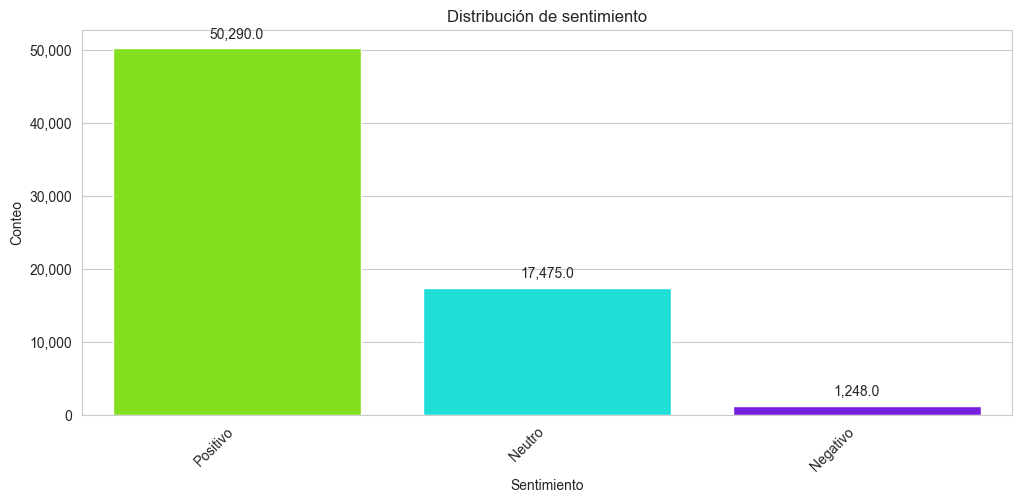

In [57]:
plot_sentiment_analysis(fine_tune_comments_df, 'fine-tuned_label')

* Vemos que los comentarios negativos son muchos menos, casi un sexto de la clasificación original. Esto es lo esperado si uno inspecciona los comentarios al azar, la mayoría son comentarios buenos, las personas disfrutan mucho el contenido del canal.
* Hubo una redistribución de comentarios desde la categoría "Negativo" a las categorías adicionales.
* Los comentarios con clasificación "perdida" de la sección anterior fueron clasificados esta vez de manera exitosa.

## Relación Positivo vs Negativo (Post fine-tuning)

Una vez que ya hemos mejorado el modelo, veamos cuales son los videos con la mejor y peor relación de sentimiento:

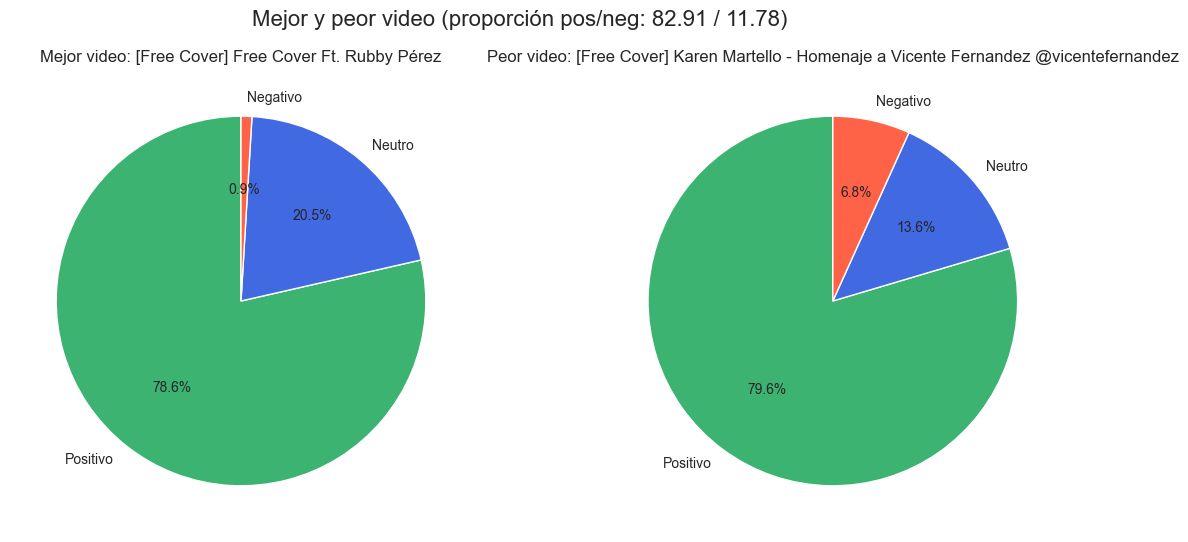

In [58]:
plot_best_worst_videos(fine_tune_comments_df, 'fine-tuned_label')

* Ahora el video con la mejor relación es el de Rubby Pérez, con una relación de 82,91.
* Recordemos que el video de Rubby Pérez tiene sobre 4000 comentarios, entonces 0,9 % de comentarios negativos se traducen en cerca de 36, claramente increíble. 
* Y ahora, el video con la relación más baja es el homenaje de Karen Martello, con una relación de 11,78 a uno.
* El video de Karen tiene alrededor de 1550 comentarios, lo que significa que existen aproximadamente 100 comentarios negativos.

In [63]:
pd.set_option('display.max_colwidth', None)
(fine_tune_comments_df
                    [
                        (fine_tune_comments_df['video_title'].str.contains('Martello'))
                        &
                        (fine_tune_comments_df['fine-tuned_label']=='Negativo')][['comment_text','fine-tuned_label']]
                        )

,comment_text,fine-tuned_label
67489,que bueno que vicente no tuvo que ver esto pobre chente que hicieron con tu musica,Negativo
67529,me encanto y q conste q tenia aburrida este genero,Negativo
67540,karen te respeto pero solo eres de hacer shows en cumpleanos voz irregular,Negativo
67543,horrible,Negativo
67571,yo creo que esta chica es tenorina no contralto llega con facilidad a notas que para las mujeres nos resulta complicado,Negativo
...,...,...
68987,no good pudo haber hecho a otro artista pero a chente a pesar de su vozno me cuadra,Negativo
69001,artista equivocado a mi criterio,Negativo
69002,me encanta karen siento q la critican por ser lesbiana solamente venezuela no avanza por eso,Negativo
69026,el primer free cover que no es de mi gusto lo siento pero es lo que pienso y siento,Negativo


## Comentarios finales

El análisis de sentimiento de los comentarios nos ha proporcionado una visión general de la opinión de la audiencia sobre los videos de FreeCover Venezuela. A partir de los resultados obtenidos, podemos extraer varias conclusiones:

    La mayoría de los comentarios son positivos, lo que indica que la audiencia disfruta del carisma y la actitud contagiosa de los artistas que se presentan en los videos.

    Los comentarios neutros en su mayoría son consultas y peticiones de nuevos artistas invitados, lo que demuestra el interés activo de la audiencia en el canal.

    Aunque existen comentarios negativos, representan una pequeña proporción de los comentarios totales. Esto sugiere que el contenido del canal tiene una aceptación generalmente positiva entre los espectadores.

    Aunque el modelo utilizado para el análisis de sentimiento tiene un "Macro F1 Score" de alrededor del 70% en su versión "vainilla", lo que indica un rendimiento aceptable en la tarea de clasificación de sentimientos con texto en español, se observa que algunos comentarios son clasificados de manera errónea, lo cual puede mejorarse mediante el proceso de fine-tuning. La razón principal observada para esta situación es la existencia de comentarios escritos con un estilo "maracaibero", es decir, las personas escriben como hablan, o utilizan frases o modismos muy propios de Maracaibo, o de Venezuela en general, para lo cual el modelo no está entrenado.

    Entre las frases o modismos utilizados por las personas, y que el modelo clasificaba erroneamente tenemos:

        * "Son unos barbaros".
        * "La parten demasiado".
        * "Está mortal este video".
        * "Vergación de bueno".
        * "No juegan carritos".

    Un porcentaje considerable de los comentarios no fue clasificado por el sistema. Es importante abordar este problema en el proceso de fine-tuning para obtener resultados más precisos y completos.

Después de aplicar el proceso de fine-tuning al modelo, se observaron cambios significativos en la distribución de los sentimientos en los comentarios:

    La cantidad de comentarios negativos disminuyó considerablemente, lo cual es esperado considerando la naturaleza positiva de la mayoría de los comentarios.

    Hubo una redistribución de los comentarios desde la categoría "Negativo" hacia las categorías adicionales, lo que indica una mejora en la precisión del modelo después del fine-tuning.

    Los comentarios que fueron clasificados como "perdidos" en la sección anterior fueron clasificados de manera exitosa esta vez, lo cual demuestra una mejora en la capacidad del modelo para comprender el sentimiento en los textos.

En cuanto a la relación entre comentarios positivos y negativos en los videos, se identificaron los videos con la mejor y peor relación:

    El video de Rubby Pérez obtuvo la mejor relación de comentarios positivos a negativos después del fine-tuning, con una proporción de 82,91 comentarios positivos por cada comentario negativo. Este resultado refleja una respuesta abrumadoramente positiva por parte de la audiencia.

    Por otro lado, el video de homenaje de Karen Martello obtuvo la tasa más baja, con una proporción de 11,78 comentarios positivos por cada comentario negativo. Aunque esta relación es relativamente baja, es importante tener en cuenta que representa solo alrededor del 6,8% de comentarios negativos.

En resumen, el análisis de sentimiento nos ha proporcionado una visión valiosa sobre la opinión de la audiencia en los videos de __FreeCover Venezuela__. El proceso de "fine-tuning" ha mejorado la precisión del modelo y ha permitido una clasificación más precisa de los sentimientos en los comentarios, podriamos decir que hizo un curso intensivo de "maracaibero" 🤣🤣🤣, lo que ayudó en la clasificación de esos comentarios escritos de manera coloquial. Estos resultados pueden ser utilizados por los creadores del canal para comprender mejor a su audiencia y mejorar la calidad de su contenido en función de los comentarios y opiniones expresadas.